<a href="https://colab.research.google.com/github/hiydavid/time-series/blob/main/ts_forecasting_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probablistic Time Series Forecasting with Transformer

In [2]:
# install
!pip install -q transformers
!pip install -q datasets
!pip install -q evaluate
!pip install -q accelerate
!pip install -q gluonts ujson

     |████████████████████████████████| 5.8 MB 33.4 MB/s 
     |████████████████████████████████| 7.6 MB 64.4 MB/s 
     |████████████████████████████████| 182 kB 79.6 MB/s 
     |████████████████████████████████| 451 kB 26.9 MB/s 
     |████████████████████████████████| 212 kB 76.4 MB/s 
     |████████████████████████████████| 132 kB 77.6 MB/s 
     |████████████████████████████████| 127 kB 80.5 MB/s 
     |████████████████████████████████| 72 kB 1.5 MB/s 
     |████████████████████████████████| 191 kB 38.0 MB/s 
     |████████████████████████████████| 1.0 MB 33.1 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 


In [47]:
# load libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datasets import load_dataset
from accelerate import Accelerator
from evaluate import load
from functools import lru_cache, partial
from typing import Optional, Iterable

# load gluonts libs
from gluonts.time_feature import (
    get_lags_for_frequency, 
    time_features_from_frequency_str, 
    TimeFeature,
    get_seasonality
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
from gluonts.transform.sampler import InstanceSampler
from gluonts.itertools import Cyclic, IterableSlice, PseudoShuffled
from gluonts.torch.util import IterableDataset

# load huggingface transformer
from transformers import (
    TimeSeriesTransformerConfig, 
    TimeSeriesTransformerForPrediction,
    PretrainedConfig
)

# load torch libs
from torch.utils.data import DataLoader
from torch.optim import Adam

## Get dataset

In [4]:
# get data
dataset = load_dataset("monash_tsf", "tourism_monthly")

Generating train split:   0%|          | 0/366 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/366 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/366 [00:00<?, ? examples/s]

Dataset monash_tsf downloaded and prepared to /root/.cache/huggingface/datasets/monash_tsf/tourism_monthly/1.0.0/82998723d55d6edbc664cfaebe371004d849846ee5f61b57f1f974000d44c050. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# view dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [6]:
# view one example
train_example = dataset['train'][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [7]:
# view time series start date (monthly)
print(train_example['start'])
print(len(train_example['target']))

1979-01-01 00:00:00
139


In [8]:
# get validation example
validation_example = dataset['validation'][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [9]:
# view the validation example
print(validation_example['start'])
print(len(validation_example['target']))

1979-01-01 00:00:00
163


In [10]:
# check to see if validation set is 24 months longer than training
freq = "1M"
prediction_length = 24

assert len(train_example['target']) + prediction_length == len(validation_example['target'])

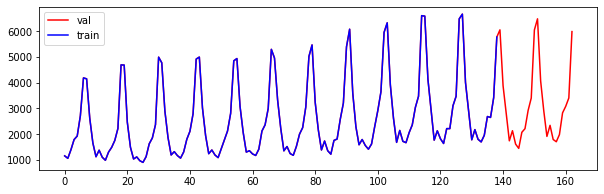

In [11]:
# plot to show
figure, axes = plt.subplots(figsize=(10, 3))
axes.plot(validation_example['target'], color="red")
axes.plot(train_example['target'], color="blue") 
plt.legend(["val", "train"])
plt.show()

In [12]:
# get test example
test_example = dataset['test'][0]
test_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [13]:
# view the test example
print(test_example['start'])
print(len(test_example['target']))

1979-01-01 00:00:00
187


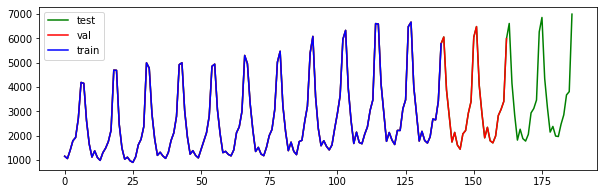

In [14]:
# plot all
figure, axes = plt.subplots(figsize=(10, 3))
axes.plot(test_example['target'], color="green")
axes.plot(validation_example['target'], color="red")
axes.plot(train_example['target'], color="blue") 
plt.legend(["test", "val", "train"])
plt.show()

In [15]:
# split the dataset in to train, val, and test
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

## Convert `start` to `pd.Period`

In [16]:
# convert
@lru_cache(10_000) # for caching
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

## Define model

In [17]:
# first create some lag features
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [18]:
# then get month of yeat feature
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function month_of_year at 0x7fef241e9e50>]


In [19]:
# define a config and define a model
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=prediction_length*3,
    lags_sequence=lags_sequence,
    num_time_features=len(time_features) + 1,
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    embedding_dimension=[2],
    encoder_layers=4, 
    decoder_layers=4,
)

model = TimeSeriesTransformerForPrediction(config)

## Define transformation and create features

In [20]:
# chain together several feature transformations
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:

    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)

    # a bit like torchvision.transforms.Compose
    return Chain(
        
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]

        # step 2: use static features if available, if not add dummy values
        + (
            [SetField(output_field=FieldName.FEAT_STATIC_CAT, value=[0])]
            if not config.num_static_categorical_features > 0
            else []
        )
        + (
            [SetField(output_field=FieldName.FEAT_STATIC_REAL, value=[0.0])]
            if not config.num_static_real_features > 0
            else []
        )
        # step 3: convert the data to NumPy (potentially not needed)
        + [
            AsNumpyArray(
                field=FieldName.FEAT_STATIC_CAT,
                expected_ndim=1,
                dtype=int,
            ),
            AsNumpyArray(
                field=FieldName.FEAT_STATIC_REAL,
                expected_ndim=1,
            ),
            AsNumpyArray(
                field=FieldName.TARGET,
                # in the following line, we add 1 for the time dimension
                expected_ndim=1 if config.input_size==1 else 2,
            ),
            # step 4: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 5: add temporal features based on freq of the dataset
            # month of year in this case
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 6: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 7: vertically stack all the temporal features
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + ([FieldName.FEAT_DYNAMIC_REAL] if config.num_dynamic_real_features > 0 else []),
            ),
            # step 8: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


## Define `InstanceSplitter`

In [21]:
# split train, val, test into an instance for training
def create_instance_splitter(
    config: PretrainedConfig, 
    mode: str, 
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
    ) -> Transformation:
    
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation":  validation_sampler or ValidationSplitSampler(
            min_future=config.prediction_length
        ),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=[
            "time_features",
            "observed_mask",
        ],
    )

## Create dataloaders

In [22]:
# function to create train dataloader
def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    **kwargs,
) -> Iterable:

    PREDICTION_INPUT_NAMES = [
        "static_categorical_features",
        "static_real_features",
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
        ]

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
        ]
    
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    instance_splitter = create_instance_splitter(
        config, "train"
    ) + SelectFields(TRAINING_INPUT_NAMES)
    training_instances = instance_splitter.apply(
        Cyclic(transformed_data)
        if shuffle_buffer_length is None
        else PseudoShuffled(
            Cyclic(transformed_data), 
            shuffle_buffer_length=shuffle_buffer_length,
        )
    )
    return IterableSlice(
        iter(
            DataLoader(
                IterableDataset(training_instances),
                batch_size=batch_size,
                **kwargs,
            )
        ),
        num_batches_per_epoch,
    )

In [23]:
# function to create test dataloader
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "static_categorical_features",
        "static_real_features",
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
        ]
    
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)
    instance_splitter = create_instance_splitter(
        config, "test"
    ) + SelectFields(PREDICTION_INPUT_NAMES)
    testing_instances = instance_splitter.apply(transformed_data, is_train=False)
    return DataLoader(IterableDataset(testing_instances), batch_size=batch_size, **kwargs)

In [24]:
# create dataloaders
train_dataloader = create_train_dataloader(
    config=config, 
    freq=freq, 
    data=train_dataset, 
    batch_size=256, 
    num_batches_per_epoch=100,
)
test_dataloader = create_test_dataloader(
    config=config, 
    freq=freq, 
    data=test_dataset,
    batch_size=64,
)

In [25]:
# check first batch
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape, v.type())

static_categorical_features torch.Size([256, 1]) torch.LongTensor
static_real_features torch.Size([256, 1]) torch.FloatTensor
past_time_features torch.Size([256, 109, 2]) torch.FloatTensor
past_values torch.Size([256, 109]) torch.FloatTensor
past_observed_mask torch.Size([256, 109]) torch.FloatTensor
future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


## Forward pass

In [26]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True
)

print("Loss:", outputs.loss.item())

Loss: 8.935521125793457


## Train the model

In [27]:
# train with accelerator
accelerator = Accelerator()
device = accelerator.device
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
 
model, optimizer, train_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, 
)

losses = []
for epoch in range(40):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device),
            static_real_features=batch["static_real_features"].to(device),
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss
        accelerator.backward(loss)
        optimizer.step()
        losses.append(loss.item())

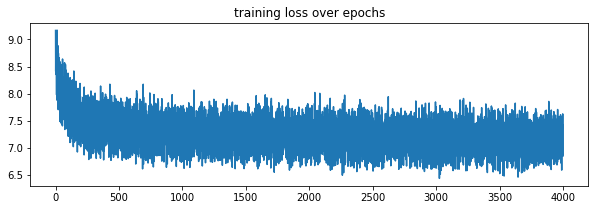

In [43]:
# plot losses
plt.figure(figsize=(10, 3))
plt.plot(losses)
plt.title("training loss over epochs")
plt.show()

## Inference

In [31]:
# create a forecast
model.eval()
forecasts = []
for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device),
        static_real_features=batch["static_real_features"].to(device),
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [32]:
# stack the forecast outputs
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(366, 100, 24)


In [38]:
# evaluate
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")
forecast_median = np.median(forecasts, 1)
mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]

    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])

In [39]:
# print
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

MASE: 1.4180274898112717
sMAPE: 0.1739779321667733


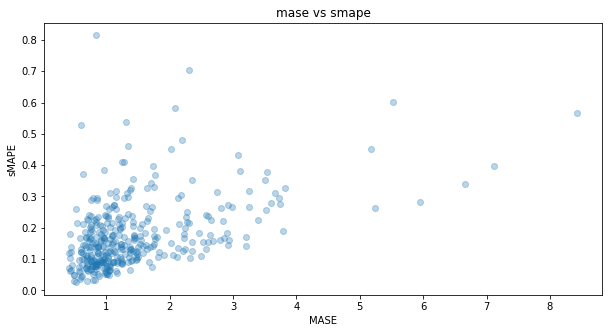

In [46]:
# plot two metrics
plt.figure(figsize=(10, 5))
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.title("mase vs smape")
plt.show()

In [54]:
# function to plot
def plot(ts_index):
    fig, ax = plt.subplots(figsize=(10, 3))

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.title(f"plot: {ts_index}")
    plt.show()

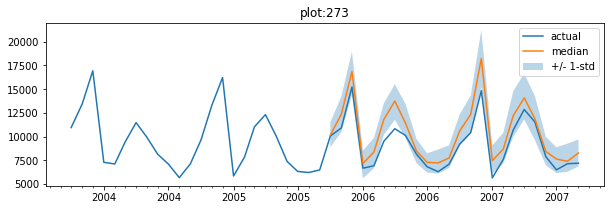

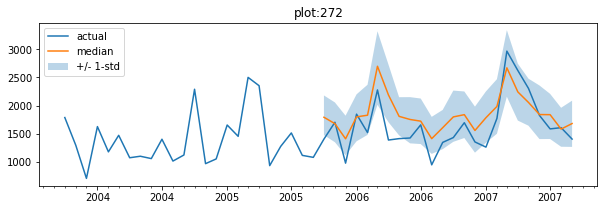

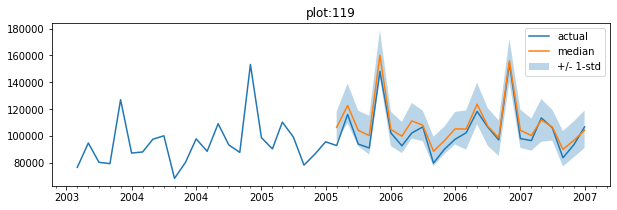

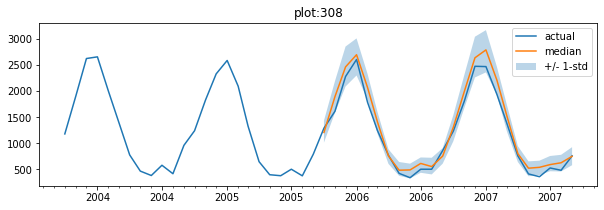

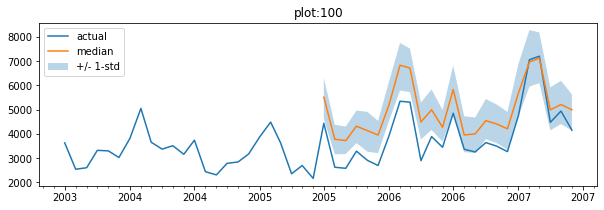

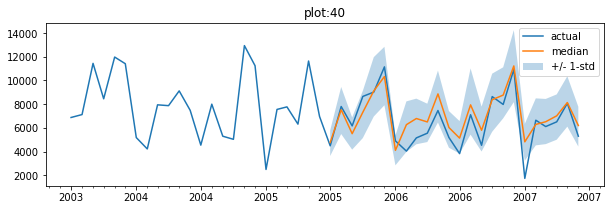

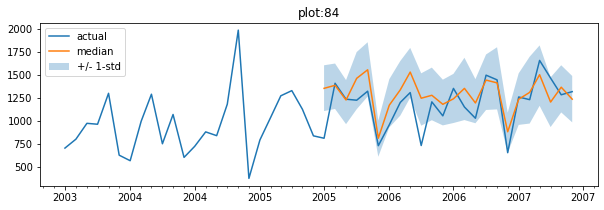

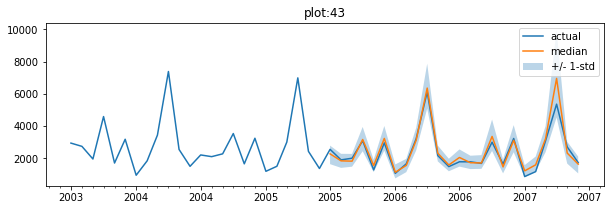

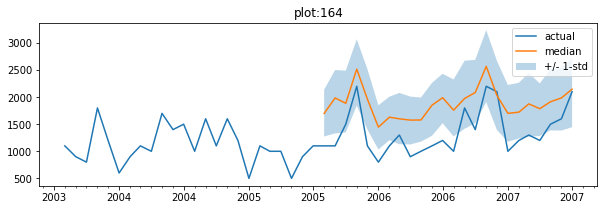

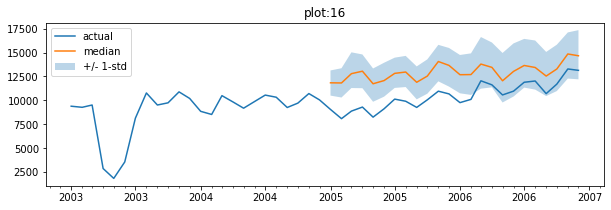

In [70]:
# plot a few examples
ts_examples = np.random.randint(365, size=10)

for i in ts_examples:
    plot(int(i))